# 🧪 Análisis de Dinámica Molecular (MD) de PIA-KRASv2-Nb

Este cuaderno de Google Colab está diseñado para analizar simulaciones de dinámica molecular de un nanobody candidato frente a KRAS.  
El flujo de trabajo está dividido en varias celdas, cada una con una función específica:

---

## 📌 Flujo del análisis

1. **Instalación de librerías (Celda 1)**  
   - Instala automáticamente las dependencias necesarias: `MDTraj`, `Pandas`, `Matplotlib`.  
   - Estas librerías permiten cargar, procesar y visualizar trayectorias de dinámica molecular.

2. **Carga de archivos de simulación (Celda 2)**  
   - Permite subir el archivo de **estructura** (`protein_system_CORRECTED.pdb`) y el de **trayectoria** (`trajectory.dcd`).  
   - Estos archivos son generados por motores de simulación como AMBER, GROMACS o NAMD.

3. **Análisis de RMSD (Celda 3)**  
   - Calcula el **Desplazamiento Medio Cuadrático (RMSD)** para:
     - El armazón del nanobody (Framework).  
     - Los bucles de unión (CDRs).  
   - Exporta los valores a un archivo `.csv` y genera un gráfico de estabilidad conformacional a lo largo del tiempo de simulación.

4. **Análisis de red de contactos (Celda 4)**  
   - Detecta y cuantifica el número de **pares de residuos en contacto (< 4 Å)** entre el nanobody y KRAS durante toda la trayectoria.  
   - Produce un archivo `.csv` con la evolución de los contactos y un gráfico comparando con la predicción estática de AlphaFold.

5. **Análisis estadístico de tendencias (Celda 5)**  
   - Aplica una **regresión lineal** al número de contactos residuo-residuo a lo largo del tiempo.  
   - Informa si existe una tendencia estadísticamente significativa (p-valor < 0.05) de aumento o disminución en la estabilidad de la interfaz.

---

## 📊 Resultados esperados
- **Archivos `.csv` descargables** con los valores de RMSD y número de contactos.  
- **Gráficos de estabilidad conformacional y contactos** listos para incluir en informes o publicaciones.  
- **Estadísticos clave (pendiente, p-valor, R²)** para validar la robustez de la interacción.  

---

➡️ En conjunto, este cuaderno permite evaluar de forma cuantitativa si el complejo Nanobody–KRAS es estable durante la simulación de dinámica molecular y si presenta señales de robustez estructural que justifiquen su validación experimental.


In [ ]:
# --- Celda 1: Instalar Librerías de Análisis ---
print("Instalando las librerías necesarias para el análisis (MDTraj, Pandas)...")
!pip install mdtraj pandas matplotlib &> /dev/null
print("¡Instalación completada!")

Instalando las librerías necesarias para el análisis (MDTraj, Pandas)...
¡Instalación completada!


In [ ]:
# --- Celda 2: Subir Archivos de Simulación ---
from google.colab import files

print("Por favor, selecciona el archivo de ESTRUCTURA (protein_system_CORRECTED.pdb)...")
files.upload()

print("\nAhora, selecciona el archivo de TRAYECTORIA (trajectory.dcd)...")
files.upload()

print("\n¡Archivos subidos con éxito!")

Por favor, selecciona el archivo de ESTRUCTURA (protein_system_CORRECTED.pdb)...


Saving protein_system_CORRECTED (1).pdb to protein_system_CORRECTED (1).pdb

Ahora, selecciona el archivo de TRAYECTORIA (trajectory.dcd)...


Saving trajectory.dcd to trajectory.dcd

¡Archivos subidos con éxito!


--- Iniciando análisis de RMSD de la trayectoria ---

Cargando la estructura y la trayectoria...
Trayectoria cargada: 5000 fotogramas.
Duración real de la trayectoria analizada: 10.0 ns
Nanobody identificado en Cadena: 0, KRAS en Cadena: 1

Alineando trayectoria y calculando RMSD...
Cálculos completados.

Creando el archivo 'rmsd_analysis_10.0ns.csv'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

¡Exportación a CSV completada!

Generando gráfico de análisis de RMSD...


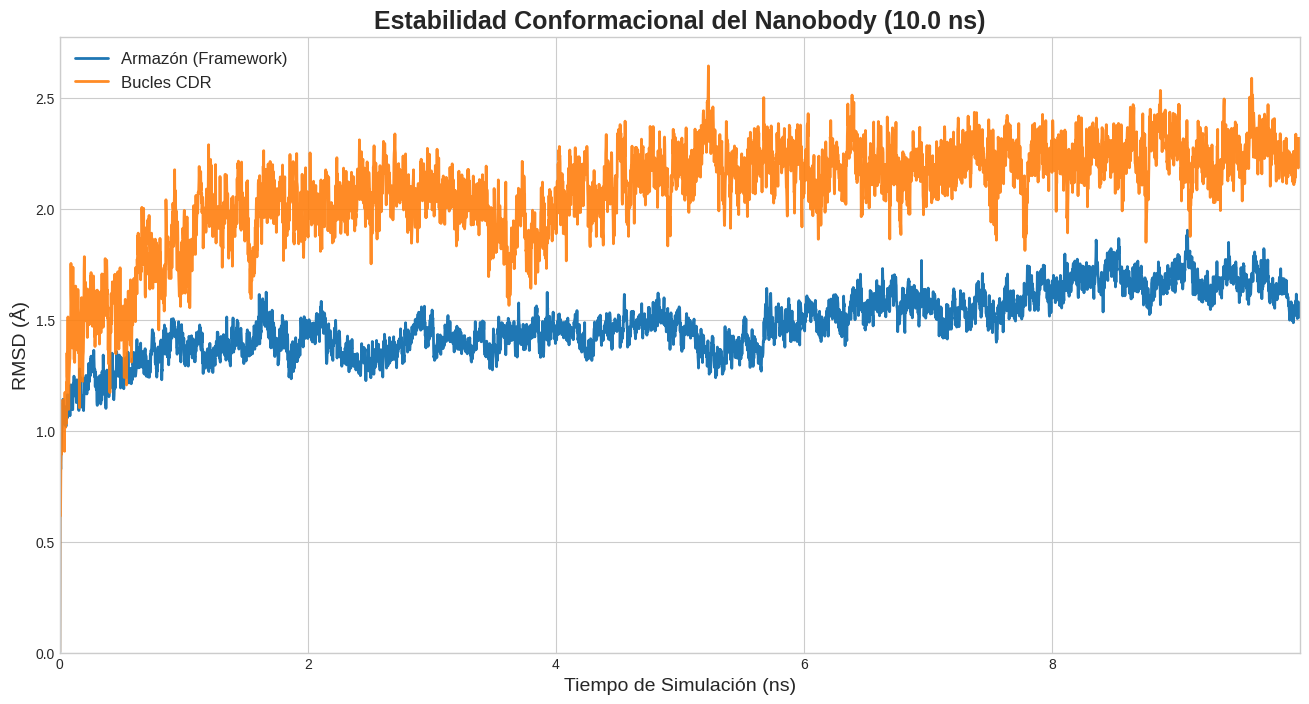

In [ ]:
# --- Celda 3: Análisis de RMSD para la Simulación de 10 ns ---

print("--- Iniciando análisis de RMSD de la trayectoria ---")

import mdtraj as md
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import files

# ==============================================================================
# >> PANEL DE CONTROL <<
# ==============================================================================
PDB_FILE = "protein_system_CORRECTED.pdb"
TRAJECTORY_FILE = "trajectory.dcd"
# Parámetros REALES de tu simulación (para construir el eje de tiempo correcto)
TIMESTEP_FS = 2.0
REPORT_INTERVAL_STEPS = 1000
# ==============================================================================

if not os.path.exists(PDB_FILE) or not os.path.exists(TRAJECTORY_FILE):
    print(f"\n¡Error! No se encuentran los archivos.")
else:
    print(f"\nCargando la estructura y la trayectoria...")
    traj = md.load(TRAJECTORY_FILE, top=PDB_FILE)
    print(f"Trayectoria cargada: {traj.n_frames} fotogramas.")

    # --- Construcción Manual y Robusta del Eje de Tiempo ---
    TIME_PER_FRAME_PS = (TIMESTEP_FS * REPORT_INTERVAL_STEPS) / 1000.0
    time_ns = (np.arange(traj.n_frames) * TIME_PER_FRAME_PS) / 1000.0
    SIMULATION_TIME_NS = time_ns[-1]
    print(f"Duración real de la trayectoria analizada: {SIMULATION_TIME_NS:.1f} ns")

    # --- Diagnóstico automático de cadenas ---
    protein_chains = [chain for chain in traj.topology.chains if any(res.is_protein for res in chain.residues)]
    if len(protein_chains) < 2:
        raise SystemExit("Error: No se encontraron al menos dos cadenas de proteína.")
    chain_lengths = [(chain.index, len([res for res in chain.residues if res.is_protein])) for chain in protein_chains]
    chain_lengths.sort(key=lambda x: x[1], reverse=True)
    nanobody_chain_id = chain_lengths[0][0]
    kras_chain_id = chain_lengths[1][0]
    print(f"Nanobody identificado en Cadena: {nanobody_chain_id}, KRAS en Cadena: {kras_chain_id}")

    # --- Selecciones para RMSD ---
    fw_indices_str = f'protein and chainid {nanobody_chain_id} and (resid 0 to 25 or resid 33 to 49 or resid 58 to 94 or resid 103 to 112)'
    cdr_indices_str = f'protein and chainid {nanobody_chain_id} and (resid 26 to 32 or resid 50 to 57 or resid 95 to 102)'
    nanobody_framework_atoms = traj.topology.select(fw_indices_str)
    nanobody_cdr_atoms = traj.topology.select(cdr_indices_str)

    # --- Cálculos de RMSD ---
    print("\nAlineando trayectoria y calculando RMSD...")
    reference_indices = traj.topology.select(f'protein and chainid {kras_chain_id} and backbone')
    traj.superpose(traj, frame=0, atom_indices=reference_indices)

    rmsd_framework = md.rmsd(traj, traj, frame=0, atom_indices=nanobody_framework_atoms) * 10
    rmsd_cdrs = md.rmsd(traj, traj, frame=0, atom_indices=nanobody_cdr_atoms) * 10
    print("Cálculos completados.")

    # --- Exportación a CSV (solo datos de RMSD) ---
    OUTPUT_CSV_FILE = f"rmsd_analysis_{SIMULATION_TIME_NS:.1f}ns.csv"
    print(f"\nCreando el archivo '{OUTPUT_CSV_FILE}'...")
    df = pd.DataFrame({
        'Time_ns': time_ns,
        'RMSD_Framework_A': rmsd_framework,
        'RMSD_CDRs_A': rmsd_cdrs
    })
    df.to_csv(OUTPUT_CSV_FILE, index=False, float_format='%.4f')
    files.download(OUTPUT_CSV_FILE)
    print(f"¡Exportación a CSV completada!")

    # --- Generación del Gráfico de RMSD ---
    print("\nGenerando gráfico de análisis de RMSD...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    plt.plot(df['Time_ns'], df['RMSD_Framework_A'], label='Armazón (Framework)', linewidth=2)
    plt.plot(df['Time_ns'], df['RMSD_CDRs_A'], label='Bucles CDR', linewidth=2, alpha=0.9)

    plt.title(f'Estabilidad Conformacional del Nanobody ({SIMULATION_TIME_NS:.1f} ns)', fontsize=18, fontweight='bold')
    plt.xlabel('Tiempo de Simulación (ns)', fontsize=14)
    plt.ylabel('RMSD (Å)', fontsize=14)
    plt.legend(loc='upper left', fontsize=12)
    plt.ylim(bottom=0)
    plt.xlim(left=0, right=SIMULATION_TIME_NS)

    plt.savefig(f'rmsd_analysis_plot_{SIMULATION_TIME_NS:.1f}ns.png', dpi=300, bbox_inches='tight')
    plt.show()

Instalando librerías necesarias (MDTraj, Pandas)...
Librerías importadas.

Cargando la estructura y la trayectoria...
Trayectoria cargada: 5000 fotogramas.

Identificando los residuos del epítopo y del nanocuerpo por cadena...
Se analizarán 120 residuos del Nanobody (Cadena 0).
Se analizarán 10 residuos del Epítopo de KRAS (Cadena 1).

Calculando el número de pares de residuos en contacto (método optimizado)...
Cálculo completado. Número medio de contactos: 29.17

Creando y descargando el archivo de datos CSV...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Archivo 'contact_analysis_residue_level_10.0ns_CORRECTED.csv' descargado.

Generando el gráfico de la red de contactos con el eje de tiempo corregido...


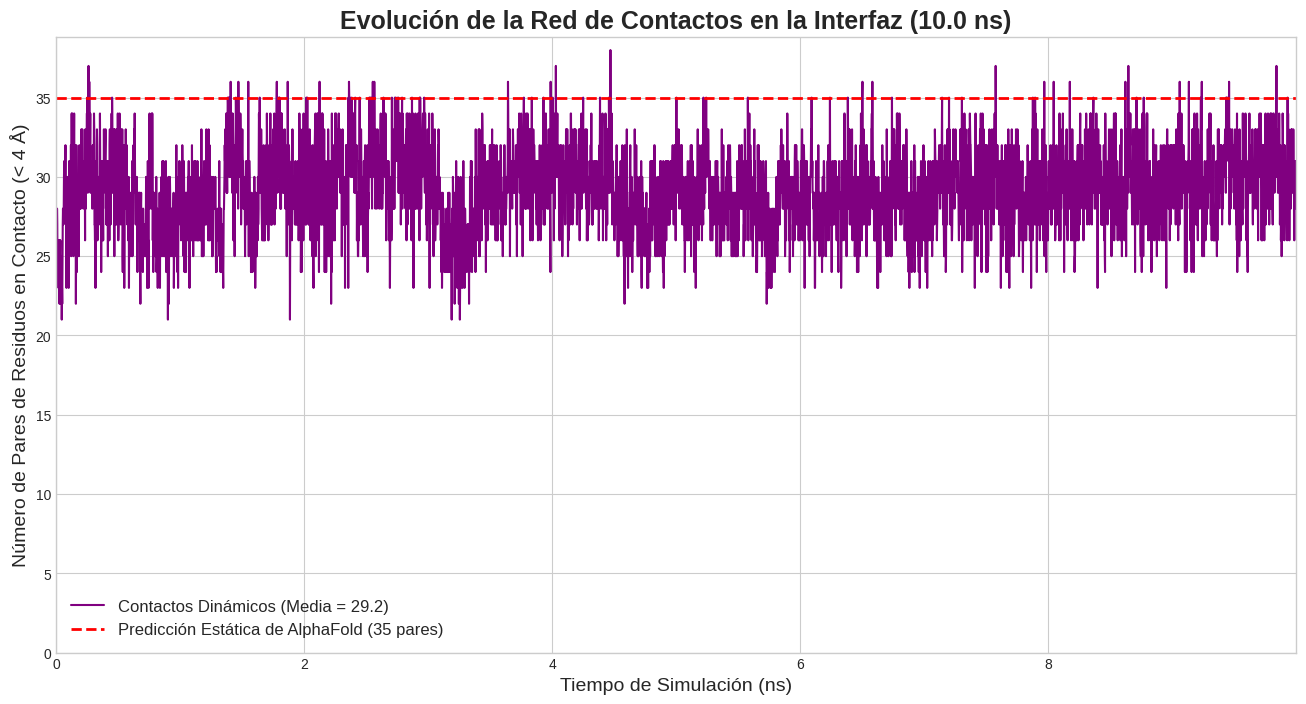

In [ ]:

# --- Celda 4 Análisis de red de contactos ---
# --- Paso 1: Instalar e importar las librerías necesarias ---
print("Instalando librerías necesarias (MDTraj, Pandas)...")
!pip install mdtraj pandas &> /dev/null
import mdtraj as md
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
from google.colab import files

print("Librerías importadas.")

# --- Paso 2: Definir archivos y parámetros ---
PDB_FILE = "protein_system_CORRECTED.pdb"
TRAJECTORY_FILE = "trajectory.dcd"
contact_cutoff_A = 4.0
contact_cutoff_nm = contact_cutoff_A / 10.0

# --- Paso 3: Cargar la trayectoria ---
if not os.path.exists(PDB_FILE) or not os.path.exists(TRAJECTORY_FILE):
    print(f"\n¡Error! No se encuentran los archivos.")
else:
    print("\nCargando la estructura y la trayectoria...")
    traj = md.load(TRAJECTORY_FILE, top=PDB_FILE)
    topology = traj.topology
    print(f"Trayectoria cargada: {traj.n_frames} fotogramas.")

    # --- Paso 4: SELECCIÓN BASADA EN LA ESTRUCTURA REAL (CADENAS SEPARADAS) ---
    print("\nIdentificando los residuos del epítopo y del nanocuerpo por cadena...")

    # Basado en el diagnóstico, Nanobody es la Cadena 0 y KRAS la Cadena 1
    nanobody_residues = [res.index for res in topology.chain(0).residues if res.is_protein]
    kras_epitope_residues = [res.index for res in topology.chain(1).residues if res.is_protein]

    if not kras_epitope_residues or not nanobody_residues:
        print("\n¡Error en la selección! No se pudieron encontrar residuos de proteína en las Cadenas 0 y 1.")
    else:
        print(f"Se analizarán {len(nanobody_residues)} residuos del Nanobody (Cadena 0).")
        print(f"Se analizarán {len(kras_epitope_residues)} residuos del Epítopo de KRAS (Cadena 1).")

        # --- Paso 5: MÉTODO OPTIMIZADO - Calcular contactos ---
        print("\nCalculando el número de pares de residuos en contacto (método optimizado)...")

        residue_pairs_to_check = list(itertools.product(nanobody_residues, kras_epitope_residues))
        distances, pairs = md.compute_contacts(traj, contacts=residue_pairs_to_check, scheme='closest-heavy')
        contact_counts = np.sum(distances < contact_cutoff_nm, axis=1)
        average_contacts = np.mean(contact_counts)
        print(f"Cálculo completado. Número medio de contactos: {average_contacts:.2f}")

        # --- Paso 6: Crear y descargar el archivo .csv ---
        print("\nCreando y descargando el archivo de datos CSV...")

        # Construimos el eje de tiempo correcto manualmente.
        time_ps = np.arange(traj.n_frames) * 2.0
        time_ns = time_ps / 1000.0
        # CAMBIO 1: Calcular la duración real para usarla en los nombres de archivo
        SIMULATION_TIME_NS = time_ns[-1]

        df = pd.DataFrame({'Time_ns': time_ns, 'NumberOfResidueContacts': contact_counts})
        # CAMBIO 2: Actualizar el nombre del archivo CSV
        csv_filename = f'contact_analysis_residue_level_{SIMULATION_TIME_NS:.1f}ns_CORRECTED.csv'
        df.to_csv(csv_filename, index=False)
        files.download(csv_filename)
        print(f"Archivo '{csv_filename}' descargado.")

        # --- Paso 7: Generar el gráfico ---
        print("\nGenerando el gráfico de la red de contactos con el eje de tiempo corregido...")
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(16, 8))

        plt.plot(time_ns, contact_counts, label=f'Contactos Dinámicos (Media = {average_contacts:.1f})', color='purple', linewidth=1.5)
        plt.axhline(y=35, color='red', linestyle='--', linewidth=2, label='Predicción Estática de AlphaFold (35 pares)')

        # CAMBIO 3: Actualizar el título y los límites del gráfico
        plt.title(f'Evolución de la Red de Contactos en la Interfaz ({SIMULATION_TIME_NS:.1f} ns)', fontsize=18, fontweight='bold')
        plt.xlabel('Tiempo de Simulación (ns)', fontsize=14)
        plt.ylabel('Número de Pares de Residuos en Contacto (< 4 Å)', fontsize=14)
        plt.legend(loc='lower left', fontsize=12) # Cambiado a 'upper left' por si la línea sube

        plt.ylim(bottom=0)
        plt.xlim(left=0, right=SIMULATION_TIME_NS)

        plt.savefig(f'contact_network_plot_{SIMULATION_TIME_NS:.1f}ns_final.png', dpi=300, bbox_inches='tight')
        plt.show()

In [ ]:
# --- Celda 5 Análisis Estadístico de Tendencia ---

print("--- Iniciando análisis de regresión lineal ---")

import pandas as pd
from scipy import stats
import os

CSV_FILE = 'contact_analysis_residue_level_FINAL.csv'

if not os.path.exists(CSV_FILE):
    print(f"\n¡Error! No se encuentra el archivo '{CSV_FILE}'.")
    print("Asegúrate de haber ejecutado primero la celda de análisis que genera el CSV.")
else:
    try:
        # Cargar los datos desde el archivo CSV
        df = pd.read_csv(CSV_FILE)

        # Extraer las columnas de tiempo y número de contactos
        time = df['Time_ns']
        contacts = df['NumberOfResidueContacts']

        # Realizar la regresión lineal
        slope, intercept, r_value, p_value, std_err = stats.linregress(time, contacts)

        # --- Presentar los resultados de forma clara ---
        print("\n=======================================================")
        print("    Resultados del Análisis de Tendencia")
        print("=======================================================")
        print(f"Pendiente (Slope) de la tendencia: {slope:.4f} contactos/ns")
        print(f"P-valor (significancia estadística): {p_value:.6f}")
        print(f"Coeficiente de correlación (R^2): {r_value**2:.4f}")
        print("=======================================================")

        # --- Interpretación de los resultados ---
        print("\nInterpretación:")

        if p_value < 0.05:
            print("✅ El p-valor es menor que 0.05, lo que indica que la tendencia es ESTADÍSTICAMENTE SIGNIFICATIVA.")
            if slope > 0:
                print(f"   Tu observación es CORRECTA. Hay una tendencia clara y medible al AUMENTO en el número de contactos.")
                print(f"   En promedio, el complejo gana aproximadamente {slope:.2f} pares de residuos en contacto por cada nanosegundo de simulación.")
            elif slope < 0:
                print(f"   Hay una tendencia clara y medible a la DISMINUCIÓN en el número de contactos.")
                print(f"   En promedio, el complejo pierde aproximadamente {abs(slope):.2f} pares de residuos en contacto por cada nanosegundo.")
            else:
                print("   La pendiente es prácticamente cero, por lo que no hay una tendencia significativa al alza o a la baja.")
        else:
            print("❌ El p-valor es mayor que 0.05, lo que indica que la tendencia observada NO es estadísticamente significativa.")
            print("   Las fluctuaciones en el número de contactos se consideran ruido aleatorio alrededor de la media, sin una dirección clara al alza o a la baja.")

    except Exception as e:
        print(f"\nOcurrió un error durante el análisis: {e}")